In [1]:
import hdbscan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
import os
import json
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)

In [21]:
# MATERIAL_PATH = "../All_mat_new_test_score_with_horz_flat_index.csv"
# DATA_PATH = "../../data"

# "henry's local data path"
DATA_PATH = "../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA"

## Start with Anupam's list of materials

In [22]:
material_df = pd.read_csv("../All_mat_new_test_score_with_horz_flat_index.csv", index_col="ID")
print(material_df.shape)
material_df.head()

(5270, 24)


,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,...,D,E,F,radio,f_orb,sg_sto_group,percentage_flat
ID,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,276.0,24.2
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN


In [23]:
# Select flat materials only
flat_df = material_df[material_df.horz_flat_seg > 0]
flat_df.shape

(2005, 24)

## Fingerprint Functions Here
Fingerprint functions take material ID as only input

In [24]:
def calc_gamma_fingerprint(material_id, fingerprint_length, e_range=[-8, 8]):
    global edges
    filename_bands=DATA_PATH+"/bands/"+material_id+'.json'
    if not os.path.isfile(filename_bands):
        print("!!!! No such file %s" % filename_bands)
    bands_dict=json.load(open(filename_bands))

    band_energies = np.array(bands_dict["bands"]["1"]) - bands_dict["efermi"]
    band_energies_gamma = band_energies[:, 0]
    counts, edges = np.histogram(band_energies_gamma, bins=fingerprint_length, range=e_range)
    return counts
    

calc_gamma_fingerprint("2dm-1", 32)

array([0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 1, 0, 0,
       0, 0, 1, 0, 1, 2, 0, 1, 1, 0], dtype=int64)

In [33]:
def calc_DOS_fingerprint(matid, fingerprint_length, e_range=[-9, 9]):
    # DOS_fingerprint_length; clustering may be sensitive to this! - encoding of sharp peaks is very sensitive to this
    # as if the value is too low, sharp peaks get averaged out and so the flat band corresponding to the peak isnt enconded as being as flat as it is
    
    # create list of energies between which, the DOS value is averaged (ensures fingerprints are same length for all materials)
    energy_bins = np.linspace(e_range[0],e_range[1], fingerprint_length+1)
    
    # HENRY SYSTEM PATHS TO MATERIAL DATA
    #path_db = 'C:/Users/hkpen/MPhys_Project/data extraction+fingerprinting/'
    #DATA_PATH = henry_path_db+'FULL_MATPEDIA_DATA/'
    
    # TOM SYSTEM PATHS TO MATERIAL DATA are set above already

    DOS_dir= DATA_PATH+'/dos/'
    filename_dos=DOS_dir+matid+'.json'
    if not os.path.isfile(filename_dos):      ###when DOS is not available
        print("No such file %s" % filename_dos)
        #formulae=strDict['formula_pretty']
        #print(formulae)
        #list_comp=chemparse.parse_formula(formulae)
        #print(type(list_comp))
        #bb=min(list_comp, key=list_comp.get)
        #print(bb)
        
    else:
        dos_dict=json.load(open(filename_dos))   ### when atom projected DOS is available
        E_fermi=dos_dict['efermi']
        
        energies = np.array(dos_dict['energies'])
        densities = np.array(dos_dict['densities']['1'])
        
        shifted_E = energies-E_fermi*np.ones(len(energies))
        
        # plt.plot(shifted_E, densities)
        # plt.ylabel('density of states (states / eV)')
        # plt.xlabel('energy-E_fermi / eV')
        # plt.xlim(-10,10)
        # plt.show()
        
        # array to store averaged DOS values as the fingerprint
        DOS_fingerprint = np.array([])
        
        # for each energy bin, find the DOS values corresponding to energies in this range, and average them
        # this gives one value in the DOS fingerprint
        for i in range(len(energy_bins)-1):
            E_slice_mask = (shifted_E>=energy_bins[i]) & (shifted_E<=energy_bins[i+1])
            DOS_fingerprint = np.append(DOS_fingerprint, np.average(densities[E_slice_mask]))
            
            
        # plt.plot(energy_bins[:-1], DOS_fingerprint)
        # plt.ylabel('density of states (states / eV)')
        # plt.xlabel('energy-E_fermi / eV')
        # plt.xlim(-10,10)
        # plt.show()
        
        #print(shifted_E[range_mask])
        #print(len(DOS_fingerprint))
        #print(densities)
        #DOS_fingerprint = densities[range_mask][:1000]

        
        return DOS_fingerprint

#calc_DOS_fingerprint("2dm-197", 156)

In [34]:
gamma_fingerprint_length = 32
dos_fingerprint_length = 100
finger_print_array = np.zeros([len(flat_df), gamma_fingerprint_length+dos_fingerprint_length])

In [35]:
for i, material_id in enumerate(flat_df.index):
    if i % 100 == 0:
        print(i, "/", len(flat_df))

    finger_print_array[i, :gamma_fingerprint_length] = calc_gamma_fingerprint(material_id, gamma_fingerprint_length)
    finger_print_array[i, gamma_fingerprint_length:] = calc_DOS_fingerprint(material_id, dos_fingerprint_length)
print(finger_print_array)

0 / 2005
No such file ../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA/dos/2dm-300.json
100 / 2005
200 / 2005
300 / 2005
400 / 2005
500 / 2005
No such file ../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA/dos/2dm-1805.json
600 / 2005
700 / 2005
800 / 2005


C:\Users\hkpen\anaconda3\Lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\hkpen\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


900 / 2005
No such file ../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA/dos/2dm-2946.json
No such file ../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA/dos/2dm-2950.json
No such file ../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA/dos/2dm-2953.json
No such file ../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA/dos/2dm-2954.json
No such file ../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA/dos/2dm-2965.json
No such file ../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA/dos/2dm-2988.json
No such file ../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA/dos/2dm-3291.json
No such file ../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA/dos/2dm-3326.json
No such file ../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA/dos/2dm-3367.json
1000 / 2005
No such file ../../MPhys_Project/data extraction+fingerprinting/FULL

In [36]:
df = flat_df.join(pd.DataFrame(finger_print_array, index=flat_df.index))
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,...,125,126,127,128,129,130,131
ID,,,,,,,,,,,,,,,
2dm-3,TlS,AB,2,4,4,0.84646,bottom-up,...,11.756011,10.494728,8.040806,7.254350,4.873794,2.897839,0.000000
2dm-21,TaI3,AB3,162,3,3,0.88201,bottom-up,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2dm-22,Li2O,AB2,164,3,3,0.96678,bottom-up,...,1.580333,1.477861,1.193122,0.135689,0.021044,0.000000,0.000000
2dm-25,VBr4,AB4,123,3,3,0.97834,bottom-up,...,4.498250,3.757256,2.475906,0.408528,0.000000,0.000000,0.000000
2dm-29,SBr,AB,2,4,4,0.82037,bottom-up,...,13.975967,16.404883,13.836578,15.721417,15.181711,15.073922,14.877639


In [46]:
# add column for dos
df["has_dos_fingerprint"] = ~df["100"].isna()
df["32"].isna().sum()

54

In [47]:
df[df["has_dos_fingerprint"]] = df[df["has_dos_fingerprint"]].fillna(0)
df["32"].isna().sum()

53

In [48]:
# save df
df.to_csv("materials_data_and_fingerprints.csv")

In [49]:
pd.read_csv("materials_data_and_fingerprints.csv")["32"].isna().sum()

53

In [50]:
df = pd.read_csv("materials_data_and_fingerprints.csv", index_col="ID")


## Clustering

In [56]:
df = df[df.has_dos_fingerprint]
fingerprint_cols = [str(i) for i in range(32,32+100)]
fingerprint_array = df[fingerprint_cols]

clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=4, min_samples=4, p=0.2)
clusterer.fit(fingerprint_array)

labels = clusterer.labels_
df["labels"] = labels
print(np.unique(labels, return_counts=True))
df[df.labels==1].head(19)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64), array([1882,   14,    6,    5,    5,    4,    8,    6,   22], dtype=int64))


,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,...,127,128,129,130,131,has_dos_fingerprint,labels
ID,,,,,,,,,,,,,,,
2dm-786,GaAs5,AB5,26,4,4,0.83377,bottom-up,...,0.0,0.0,0.0,0.0,0.0,True,1
2dm-1625,GaP5,AB5,26,4,4,0.83131,bottom-up,...,0.0,0.0,0.0,0.0,0.0,True,1
2dm-1843,InP5,AB5,26,4,4,0.89830,bottom-up,...,0.0,0.0,0.0,0.0,0.0,True,1
2dm-2616,B2Te3,A2B3,1,4,4,0.86829,bottom-up,...,0.0,0.0,0.0,0.0,0.0,True,1
2dm-2901,B2Te3,A2B3,1,4,4,0.83736,bottom-up,...,0.0,0.0,0.0,0.0,0.0,True,1
2dm-5631,Ta3SiTe6,AB3C6,26,4,4,0.85514,top-down,...,0.0,0.0,0.0,0.0,0.0,True,1


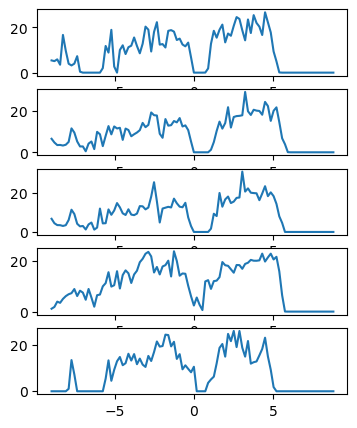

In [55]:
label = 1
num_plots = len(df[df.labels==label])

fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

for i, index in enumerate(df[df.labels==label].index):
    # ax[i].bar(edges[:-1], df.loc[index][fingerprint_cols], align="edge", width=edges[1]-edges[0])?
    ax[i].plot(np.linspace(-9, 9, 100+1)[:-1], df.loc[index][fingerprint_cols])

plt.show()

## T-SNE Plot

In [58]:
n_components=2
tsne = manifold.TSNE(n_components=n_components, early_exaggeration=12.0, init="pca",learning_rate=100, random_state=0, perplexity=30 ,n_iter=10000, verbose=2)
fingerprints_2d = tsne.fit_transform(fingerprint_array)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1952 samples in 0.002s...
[t-SNE] Computed neighbors for 1952 samples in 0.284s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1952
[t-SNE] Computed conditional probabilities for sample 1952 / 1952
[t-SNE] Mean sigma: 13.629884
[t-SNE] Computed conditional probabilities in 0.102s
[t-SNE] Iteration 50: error = 74.7238007, gradient norm = 0.0480416 (50 iterations in 1.828s)
[t-SNE] Iteration 100: error = 74.2740860, gradient norm = 0.0671082 (50 iterations in 1.147s)
[t-SNE] Iteration 150: error = 73.9724197, gradient norm = 0.0133862 (50 iterations in 0.414s)
[t-SNE] Iteration 200: error = 74.1524048, gradient norm = 0.0203115 (50 iterations in 0.395s)
[t-SNE] Iteration 250: error = 74.1756744, gradient norm = 0.0191114 (50 iterations in 0.423s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.175674
[t-SNE] Iteration 300: error = 1.9789821, gradient norm = 0.0105575 (50 iterations in 0.384s

[t-SNE] Iteration 4150: error = 1.5992622, gradient norm = 0.0003060 (50 iterations in 0.495s)
[t-SNE] Iteration 4200: error = 1.5991554, gradient norm = 0.0002692 (50 iterations in 0.505s)
[t-SNE] Iteration 4250: error = 1.5990905, gradient norm = 0.0002485 (50 iterations in 0.547s)
[t-SNE] Iteration 4300: error = 1.5990747, gradient norm = 0.0002844 (50 iterations in 0.448s)
[t-SNE] Iteration 4350: error = 1.5989873, gradient norm = 0.0002211 (50 iterations in 0.508s)
[t-SNE] Iteration 4400: error = 1.5988996, gradient norm = 0.0002049 (50 iterations in 0.478s)
[t-SNE] Iteration 4450: error = 1.5988666, gradient norm = 0.0001763 (50 iterations in 0.496s)
[t-SNE] Iteration 4500: error = 1.5988809, gradient norm = 0.0002304 (50 iterations in 0.480s)
[t-SNE] Iteration 4550: error = 1.5988235, gradient norm = 0.0001944 (50 iterations in 0.500s)
[t-SNE] Iteration 4600: error = 1.5987854, gradient norm = 0.0001877 (50 iterations in 0.493s)
[t-SNE] Iteration 4650: error = 1.5987343, gradien

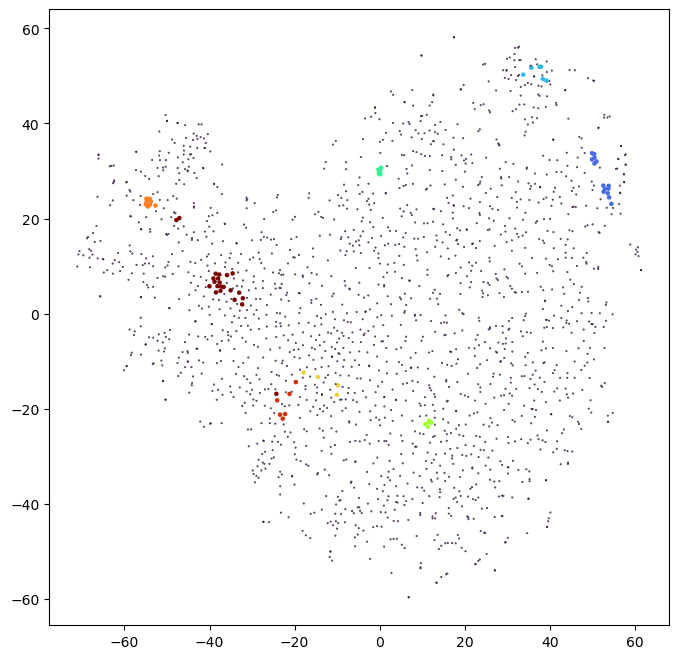

In [59]:
fig = plt.figure(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2

plt.scatter(fingerprints_2d[:,0], fingerprints_2d[:,1],s=size, c=labels*5, cmap="turbo")